<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Portfolio/risk management

### Summary
* Drawdown break strategy
* Crypto portfolio DDB
* Drawdown break portfolio



<br>


💰Join our community: https://discord.gg/wXjNPAc5BH

📚Read our book: https://www.amazon.com/gp/product/B09HG18CYL 

🖥️Quantreo's YouTube channel: https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw

In [ ]:
!pip install ta
!pip install yfinance

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=a4fc5d81f18b01ee6b76219dc05de7751fc92e58eb3da35ecf09bf4ece61a1c1
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
     |████████████████████████████████| 6.4 MB 7.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

In [ ]:
def BackTest(serie, annualiazed_scalar=252):
  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()


  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

In [ ]:
def breakout(name, cost=0.001, duration=7, dd_break=None):
  def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown
    
  def preprocessing(name):

    # Import the data
    df = pd.read_csv(f"{name}", delimiter="\t", index_col="<DATE>", parse_dates=True)

    # Delete the two last columns
    df = df.iloc[:,:-2]

    # Rename
    df.columns = ["open", "high", "low", "close", "volume"]
    df.index.name = "name"

    return df

  df = preprocessing(name)
  df["resistance"] = df["close"].rolling(30).max().shift(3)
  df["support"] = df["close"].rolling(30).min().shift(3)

  distance = 0.5/100

  # Shift the values
  df["Close Yesterday"] = df["close"].shift(1)
  df["Resistance Yesterday"] = df["resistance"].shift(1)
  df["signal_long"] = np.nan

  df.loc[(df["close"] > df["resistance"]*(1+distance)) &\
         (df["Close Yesterday"] < df["Resistance Yesterday"]), "signal_long"] = 1

  df["signal_long"] = df["signal_long"].fillna(value=0)

  # Compute the percentage of variation of the asset
  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy

  df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal_long"].shift(duration))
  # df["return"] = (df["pct"] + df["pct"].shift(9) + df["pct"].shift(8) + df["pct"].shift(7) + df["pct"].shift(6)\
  #                 + df["pct"].shift(5)+ df["pct"].shift(4)+ df["pct"].shift(3)+ df["pct"].shift(2)\
  #                 + df["pct"].shift(1)) * (df["signal_long"].shift(10))
  
  df.loc[df["signal_long"]==1,"return"]=df["return"]-cost

  if dd_break!=None:
    df["drawdown"] = drawdown_function(df["return"])
    df.loc[df["drawdown"].shift(1)<-dd_break, "return"] = 0

  return df["return"]

# Drawdown break Strategy

<p><img alt="Colaboratory logo"  src="https://www.quantreo.com/wp-content/uploads/2022/01/Capture-decran-2022-01-13-a-18.33.13.png" align="left" hspace="10px" vspace="0px"></p>


[*********************100%***********************]  1 of 1 completed


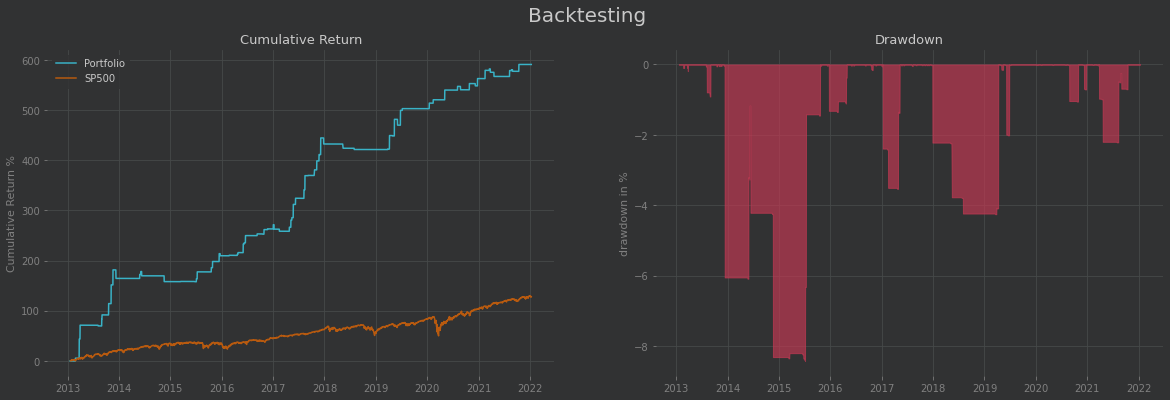

Sortino: 0.455
Beta: -0.037
Alpha: 11.248 %
MaxDrawdown: 8.422 %
[*********************100%***********************]  1 of 1 completed


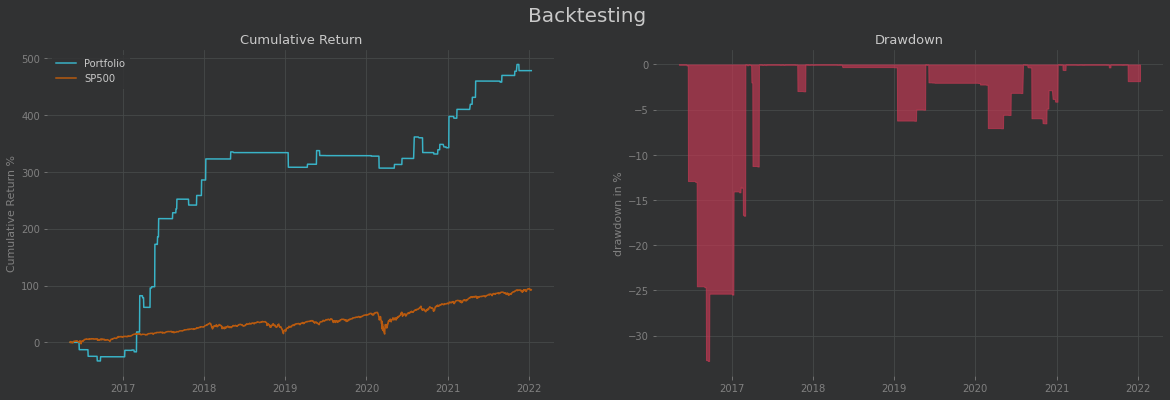

Sortino: 0.36
Beta: 0.106
Alpha: 13.472 %
MaxDrawdown: 32.808 %
[*********************100%***********************]  1 of 1 completed


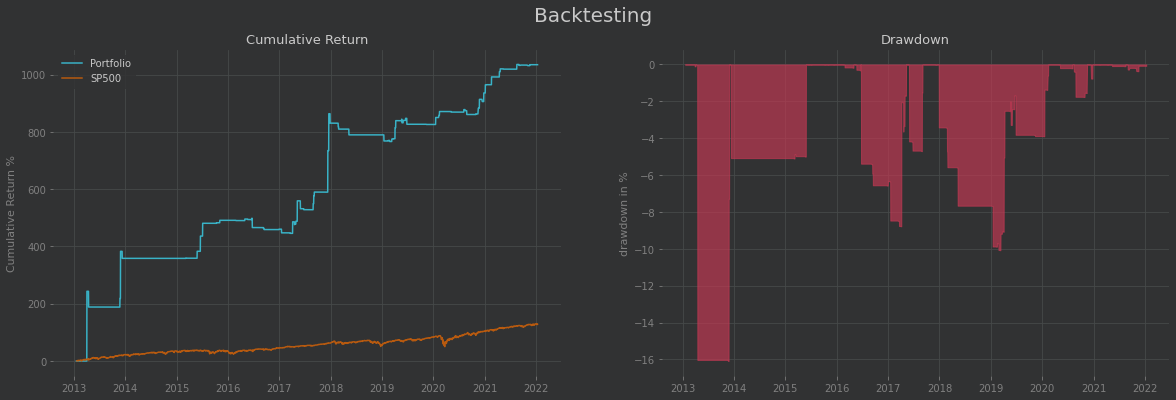

Sortino: 0.291
Beta: -0.002
Alpha: 18.118 %
MaxDrawdown: 16.081 %
[*********************100%***********************]  1 of 1 completed


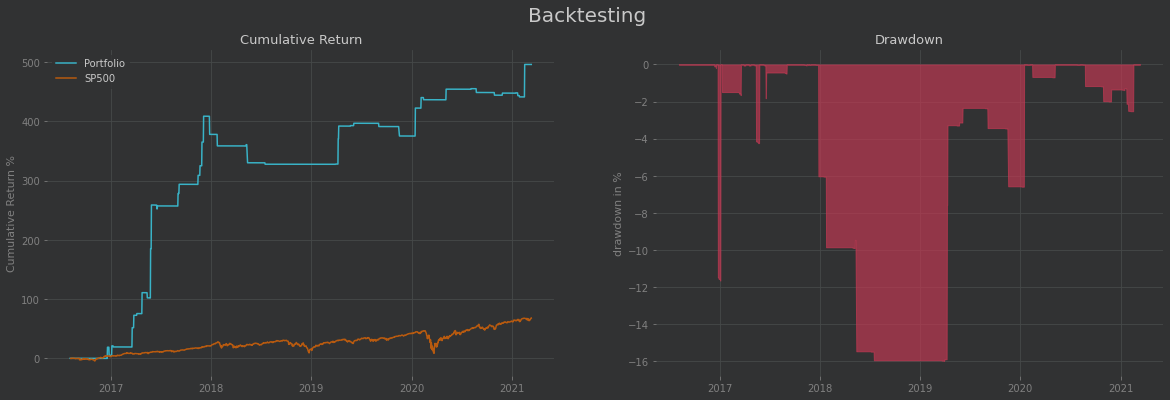

Sortino: 0.403
Beta: -0.035
Alpha: 20.037 %
MaxDrawdown: 15.972 %
[*********************100%***********************]  1 of 1 completed


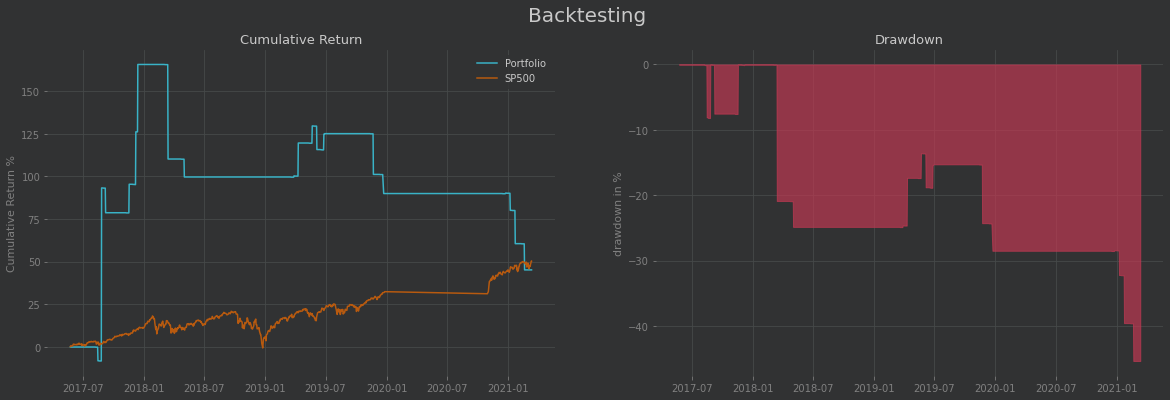

Sortino: 0.035
Beta: 0.046
Alpha: 2.805 %
MaxDrawdown: 45.331 %


In [ ]:
# DDB to 15% but we need to take the SL into account
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
  ret = breakout(f"{name}USD_D1.csv", duration=7, dd_break=0.5)
  returns = pd.concat((returns,ret),axis=1)
  BackTest(ret, 52)

# Crypto strategies portfolio

In [ ]:
def drawdown_function(serie):

    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    return drawdown

[*********************100%***********************]  1 of 1 completed


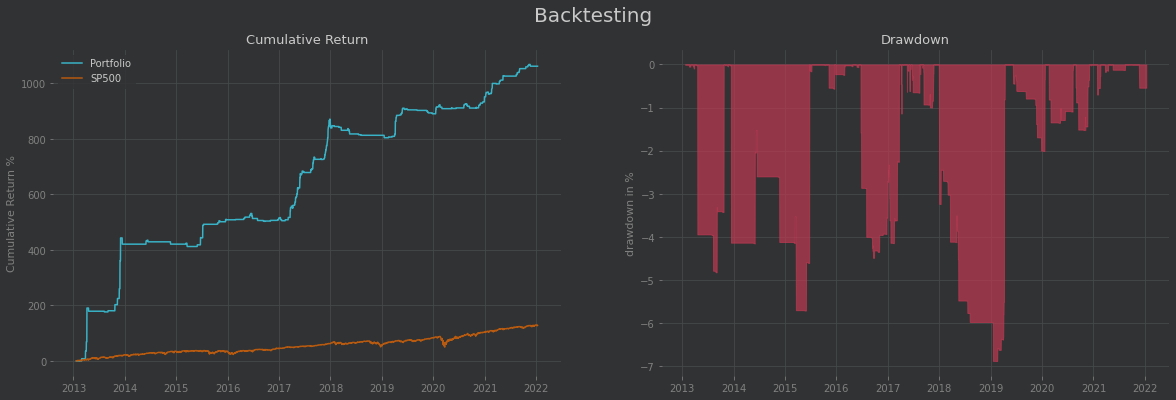

Sortino: 0.928
Beta: 0.016
Alpha: 18.108 %
MaxDrawdown: 6.876 %


In [ ]:
# DDB to 15% but we need to take the SL into account
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
  ret = breakout(f"{name}USD_D1.csv", duration=7, dd_break=0.15)
  returns = pd.concat((returns,ret),axis=1)

# Create empty DataFrame
returns_ = pd.DataFrame()

# Number of asset in the portfolio
returns_["count"] = returns.shape[1] - returns.isna().sum(axis=1)

# Portfolio creation
returns_["return"] = returns.sum(axis=1) / returns_["count"]

# Drawdown computation
returns_["drawdown"] = drawdown_function(returns_["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
returns_.loc[returns_["drawdown"].shift(1)<-0.1, "return"] = 0

BackTest(returns_["return"],52)

# Drawdown break portfolio

[*********************100%***********************]  1 of 1 completed


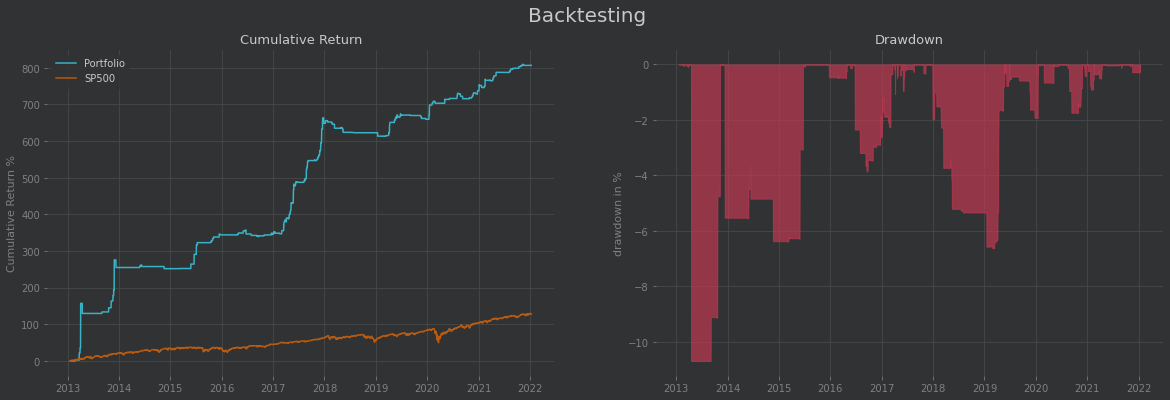

Sortino: 0.707
Beta: 0.002
Alpha: 13.935 %
MaxDrawdown: 10.691 %


In [ ]:
# DDB to 15% but we need to take the SL into account
namelist=["BTC", "ETH", "LTC", "ETC", "XMR"]

# Create empty DataFrame
returns = pd.DataFrame()

# Iterate breakout strategy with drawdown break on the asset
for name in namelist:
  ret = breakout(f"{name}USD_D1.csv", duration=7)
  returns = pd.concat((returns,ret),axis=1)

# Create empty DataFrame
returns_ = pd.DataFrame()

# Number of asset in the portfolio
returns_["count"] = returns.shape[1] - returns.isna().sum(axis=1)

# Portfolio creation
returns_["return"] = returns.sum(axis=1) / returns_["count"]

# Drawdown computation
returns_["drawdown"] = drawdown_function(returns_["return"])

# If the drawdown falls below the DDB threshold we stop the strategy TOMORROW
returns_.loc[returns_["drawdown"].shift(1)<-0.1, "return"] = 0

BackTest(returns_["return"],52)